----
## **<font color="crimson"> Ya está ok</font>**

In [1]:
pip install xarray cftime h5netcdf 

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install toolz

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install cartopy

Note: you may need to restart the kernel to use updated packages.


In [4]:
import xarray as xr
import numpy as np
import cftime
import matplotlib.pyplot as plt
import jsmetrics
import pandas as pd
def lineplot_setup(xmin,xmax,xlab,ylab,ymin=None,ymax=None,title=None,legend=False):
    # especificar limites minimos y maximos del grafico
    plt.xlim([xmin,xmax])
    plt.ylim([ymin,ymax])
    # cuadrilla interna del grafico
    plt.grid(linestyle='--',alpha=0.66)
    plt.minorticks_on()
    # hacer las etiquetas de ambos ejes mas grandes
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel(xlab,fontsize=14)
    plt.ylabel(ylab,fontsize=14)
    plt.title(title,fontsize=15)
    if legend:
        plt.legend(fancybox=True,shadow=True,fontsize=10)
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
#Histórico
uahist="datasets/ua_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc"
vahist='datasets/va_Amon_HadGEM3-GC31-LL_historical_r1i1p1f3_gn_195001-201412.nc'
uahisto=xr.open_dataset(uahist)
vahisto=xr.open_dataset(vahist)
uHG=uahisto["ua"]
vHG=vahisto["va"]

In [6]:
#ERA5
uE5ds="datasets/u_component_of_wind_1979-2024_monthly2.nc"
vE5ds='datasets/v_component_of_wind_1979-2024_monthly2 (1).nc'
uas=xr.open_dataset(uE5ds)
vas=xr.open_dataset(vE5ds)
#Checanod las unidades de la presión
uE5=uas["u"]
vE5=vas["v"]

In [7]:
print(uHG)
print(vE5)

<xarray.DataArray 'ua' (time: 780, plev: 19, lat: 145, lon: 192)> Size: 2GB
[412588800 values with dtype=float32]
Coordinates:
  * time     (time) object 6kB 1950-01-16 00:00:00 ... 2014-12-16 00:00:00
  * plev     (plev) float64 152B 1e+05 9.25e+04 8.5e+04 ... 1e+03 500.0 100.0
  * lat      (lat) float64 1kB -90.0 -88.75 -87.5 -86.25 ... 87.5 88.75 90.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
Attributes:
    standard_name:  eastward_wind
    long_name:      Eastward Wind
    comment:        Zonal wind (positive in a eastward direction).
    units:          m s-1
    original_name:  mo: (stash: m01s30i201, blev: [1000.0, 925.0, 850.0, 700....
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-06-19T11:57:01Z altered by CMOR: replaced missing va...
<xarray.DataArray 'v' (valid_time: 552, pressure_level: 14, latitude: 161,
                       longitude: 480)> Size: 2GB
[597219840 values with dtype=float32

In [8]:
#Dado que las unidades de la presión se encuentran en Pa, estas se pasarán a hPa
uHG["plev"]=uHG["plev"]/100
vHG["plev"]=vHG["plev"]/100

In [9]:
#Cambiando las unidades
uHG['units']='hPa'
vHG['units']='hPa'

In [10]:
uHG=uHG.sel(lat=slice(10, 40))#),lon=slice(0,129))
vHG=vHG.sel(lat=slice(10, 40))

In [11]:
uE5 = uE5.sel(latitude=slice(40, 10),longitude=slice(-160,0))
# aqui estaba el error
vE5 = vE5.sel(latitude=slice(40, 10),longitude=slice(-160,0))

In [12]:
uHG=uHG.where((uHG.time.dt.month==12)| (uHG.time.dt.month==1)| (uHG.time.dt.month==2),drop=True)
vHG=vHG.where((vHG.time.dt.month==12)| (vHG.time.dt.month==1)| (vHG.time.dt.month==2),drop=True)

In [13]:
uE5=uE5.where((uE5.valid_time.dt.month==12)| (uE5.valid_time.dt.month==1)| (uE5.valid_time.dt.month==2),drop=True)
vE5=vE5.where((vE5.valid_time.dt.month==12)| (vE5.valid_time.dt.month==1)| (vE5.valid_time.dt.month==2),drop=True)

In [14]:
#Definimos la posición del STJ como la latitud del valor máximo encontrado en el campo de diferencia entre el viento zonalde la
#troposfera superior (250 hPa) y el viento zonal de la troposfera inferior (850 hPa)promediado en una banda de longitud dada entre 10° y 40°N.


#Seleccionando los datos de tropósfera superior e inferior ts es la trofosfera superior y ti la infertior
tsu_hg=uHG.where(uHG["plev"]==250,drop=True).mean("time") #DROP SI TENGO UN ARCHIVO CON LOS DOS NIVELES
tsv_hg=vHG.where(vHG["plev"]==250,drop=True).mean("time")

tiu_hg=uHG.where(uHG["plev"]==700,drop=True).mean("time")
tiv_hg=vHG.where(vHG["plev"]==700,drop=True).mean("time")

#hasta aquí ok

In [15]:
#Definimos la posición del STJ como la latitud del valor máximo encontrado en el campo de diferencia entre el viento zonalde la
#troposfera superior (250 hPa) y el viento zonal de la troposfera inferior (850 hPa)promediado en una banda de longitud dada entre 10° y 40°N.

# #Seleccionando los datos de tropósfera superiod e inferior
tsu_e5=uE5.where(uE5["pressure_level"]==250,drop=True).mean("valid_time")
tsv_e5=vE5.where(vE5["pressure_level"]==250,drop=True).mean("valid_time")

tiu_e5=uE5.where(uE5["pressure_level"]==700,drop=True).mean("valid_time")
tiv_e5=vE5.where(vE5["pressure_level"]==700,drop=True).mean("valid_time")

In [16]:
#magnitud de vector con componentes u,v
uv_250= np.sqrt(tsu_hg**2 + tsv_hg**2)
uv_850= np.sqrt(tiu_hg**2 + tiv_hg**2)

In [17]:
#magnitud de vector con componentes u,v
uv_250E5= np.sqrt(tsu_e5**2 + tsv_e5**2)
uv_850E5= np.sqrt(tiu_e5**2 + tiv_e5**2)

In [18]:
uv_250

<xarray.DataArray (plev: 1, lat: 25, lon: 192)> Size: 19kB
array([[[15.644997, 14.820399, 14.060449, ..., 18.092592, 17.2789  ,
         16.46352 ],
        [18.231829, 17.42981 , 16.672035, ..., 20.65345 , 19.833439,
         19.02704 ],
        [20.941278, 20.182608, 19.45172 , ..., 23.285303, 22.49928 ,
         21.712683],
        ...,
        [16.906767, 17.41436 , 17.881144, ..., 15.834005, 16.12054 ,
         16.443178],
        [16.475508, 16.87831 , 17.226093, ..., 15.836024, 15.994693,
         16.158588],
        [16.25231 , 16.542461, 16.811493, ..., 16.01016 , 16.073584,
         16.105371]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 200B 10.0 11.25 12.5 13.75 ... 36.25 37.5 38.75 40.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
  * plev     (plev) float64 8B 250.0
    units    <U3 12B 'hPa'

In [19]:
#diferencia de niveles, pero en longitud la que sea la máxima ahí está el jet!
hg = np.abs(uv_250.isel(plev=0) - uv_850[0])

In [20]:
hg

<xarray.DataArray (lat: 25, lon: 192)> Size: 19kB
array([[13.169966, 12.695587, 12.135681, ..., 14.715249, 14.354   ,
        13.829348],
       [17.062128, 16.422043, 15.756989, ..., 18.791853, 18.34299 ,
        17.788115],
       [20.328686, 19.493858, 18.747887, ..., 22.582169, 21.964283,
        21.157255],
       ...,
       [11.055532, 11.183831, 11.16614 , ..., 10.469513, 10.378928,
        10.61813 ],
       [10.650807, 10.812398, 10.646225, ..., 10.380821, 10.15872 ,
        10.190392],
       [10.095182, 10.582514, 10.623705, ..., 10.275654,  9.991383,
         9.746717]], dtype=float32)
Coordinates:
  * lat      (lat) float64 200B 10.0 11.25 12.5 13.75 ... 36.25 37.5 38.75 40.0
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    units    <U3 12B 'hPa'

In [21]:
lat_max_diff_hg = hg.idxmax(dim='lat')
lat_max_diff_hg

<xarray.DataArray 'lat' (lon: 192)> Size: 2kB
array([22.5 , 22.5 , 22.5 , 23.75, 23.75, 23.75, 23.75, 23.75, 23.75,
       25.  , 25.  , 25.  , 25.  , 25.  , 26.25, 26.25, 26.25, 27.5 ,
       27.5 , 27.5 , 27.5 , 27.5 , 27.5 , 28.75, 28.75, 28.75, 30.  ,
       30.  , 30.  , 30.  , 30.  , 30.  , 28.75, 28.75, 28.75, 28.75,
       28.75, 28.75, 28.75, 30.  , 30.  , 30.  , 30.  , 30.  , 28.75,
       27.5 , 27.5 , 27.5 , 27.5 , 27.5 , 28.75, 27.5 , 27.5 , 27.5 ,
       28.75, 28.75, 30.  , 30.  , 30.  , 30.  , 30.  , 30.  , 30.  ,
       30.  , 30.  , 30.  , 31.25, 31.25, 31.25, 31.25, 31.25, 31.25,
       31.25, 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 ,
       32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 ,
       32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 32.5 , 31.25,
       31.25, 31.25, 31.25, 31.25, 31.25, 31.25, 30.  , 30.  , 28.75,
       28.75, 27.5 , 26.25, 26.25, 25.  , 25.  , 23.75, 23.75, 23.75,
       23.75, 23.75, 23.75, 23.75, 23.75, 23.75, 23.75, 23.75, 23.75,
       23.75, 23.75, 25.  , 25.  , 26.25, 26.25, 27.5 , 27.5 , 27.5 ,
       27.5 , 27.5 , 28.75, 28.75, 28.75, 28.75, 30.  , 30.  , 30.  ,
       31.25, 31.25, 32.5 , 32.5 , 32.5 , 32.5 , 33.75, 33.75, 33.75,
       33.75, 35.  , 35.  , 35.  , 35.  , 35.  , 36.25, 36.25, 36.25,
       23.75, 23.75, 23.75, 23.75, 23.75, 22.5 , 22.5 , 15.  , 15.  ,
       15.  , 16.25, 16.25, 17.5 , 17.5 , 17.5 , 17.5 , 18.75, 18.75,
       18.75, 20.  , 20.  , 20.  , 20.  , 21.25, 21.25, 21.25, 21.25,
       21.25, 22.5 , 22.5 ])
Coordinates:
  * lon      (lon) float64 2kB 0.0 1.875 3.75 5.625 ... 352.5 354.4 356.2 358.1
    units    <U3 12B 'hPa'

In [22]:
#diferencia de niveles
e5 = np.abs(uv_250E5[0] - uv_850E5[0] )

In [23]:
lat_max_diff_e5 = e5.idxmax(dim='latitude')
lat_max_diff_e5

<xarray.DataArray 'latitude' (longitude: 214)> Size: 2kB
array([36.  , 36.  , 36.  , 36.  , 36.  , 34.5 , 34.5 , 34.5 , 34.5 ,
       34.5 , 34.5 , 34.5 , 34.5 , 34.5 , 34.5 , 34.5 , 35.25, 23.25,
       24.  , 23.25, 22.5 , 22.5 , 22.5 , 22.5 , 24.  , 24.  , 24.  ,
       24.  , 24.  , 25.5 , 25.5 , 25.5 , 25.5 , 24.  , 24.  , 24.  ,
       23.25, 23.25, 23.25, 23.25, 24.75, 24.75, 24.75, 24.  , 24.  ,
       22.5 , 22.5 , 21.75, 21.75, 22.5 , 22.5 , 22.5 , 21.  , 24.  ,
       37.5 , 24.  , 24.75, 24.75, 24.75, 24.75, 24.75, 24.75, 24.75,
       24.75, 27.  , 27.  , 27.  , 27.75, 27.  , 26.25, 25.5 , 25.5 ,
       24.  , 27.  , 27.  , 26.25, 27.  , 26.25, 24.75, 25.5 , 30.75,
       30.75, 30.75, 27.  , 27.75, 27.75, 27.75, 27.75, 28.5 , 28.5 ,
       31.5 , 32.25, 31.5 , 31.5 , 31.5 , 31.5 , 31.5 , 31.5 , 31.5 ,
       31.5 , 33.75, 35.25, 34.5 , 38.25, 38.25, 39.  , 36.  , 36.75,
       36.75, 39.  , 39.  , 38.25, 39.  , 39.  , 39.  , 38.25, 38.25,
       38.25, 38.25, 38.25, 38.25, 36.  , 37.5 , 36.75, 38.25, 37.5 ,
       37.5 , 39.  , 39.  , 39.75, 39.75, 39.75, 39.  , 39.75, 39.75,
       39.75, 39.75, 39.75, 39.75, 39.75, 39.75, 39.75, 39.75, 39.75,
       38.25, 14.25, 13.5 , 14.25, 14.25, 14.25, 14.25, 14.25, 14.25,
       14.25, 14.25, 14.25, 15.75, 14.25, 15.75, 15.75, 15.75, 15.75,
       15.75, 15.75, 15.75, 15.75, 15.  , 15.  , 15.  , 15.  , 15.75,
       15.75, 15.75, 16.5 , 16.5 , 15.75, 15.75, 15.75, 15.75, 16.5 ,
       16.5 , 16.5 , 16.5 , 17.25, 16.5 , 16.5 , 16.5 , 16.5 , 17.25,
       17.25, 17.25, 17.25, 17.25, 21.  , 21.  , 20.25, 20.25, 20.25,
       21.  , 21.  , 20.25, 21.  , 21.  , 21.  , 21.  , 21.75, 21.75,
       21.75, 21.75, 22.5 , 21.75, 21.75, 21.75, 21.75])
Coordinates:
    number     int64 8B 0
  * longitude  (longitude) float64 2kB -159.8 -159.0 -158.2 ... -1.5 -0.75 0.0

In [24]:
lat_max_diff_smooth = lat_max_diff_hg.rolling(lon=3, center=True).mean()
lat_max_diff_e5 = lat_max_diff_e5.rolling(longitude=4,center=True).mean()

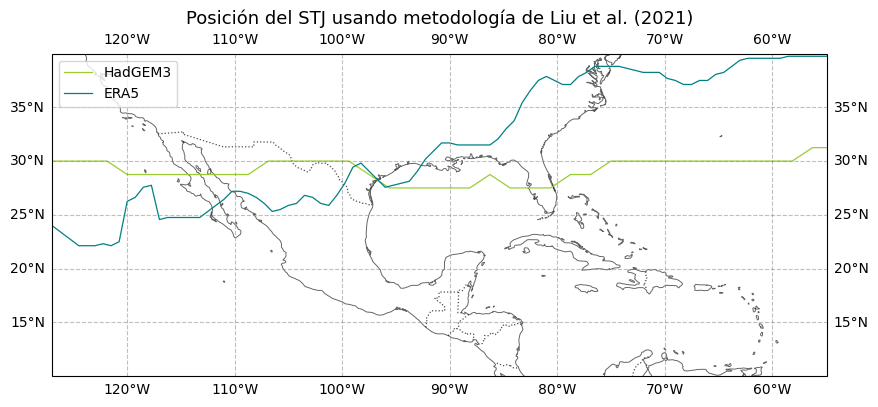

In [25]:
fig = plt.figure(figsize=(10, 10))
# hacemos objeto de mapa
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(linewidth=0.7,alpha=0.6)
# agregamos lineas costeras
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.9,alpha=0.7)
ax.plot(lat_max_diff_hg.lon-180,lat_max_diff_hg, label="HadGEM3",c='yellowgreen', linewidth=0.9)
# ax.fill_between(a.lon-180, bp2, bp1, alpha=0.4,color="black")
ax.plot(lat_max_diff_e5.longitude,lat_max_diff_e5, label="ERA5",c='teal',linewidth=0.9)
# ax.fill_between(s.lon-180, s, s-, alpha=0.4,color="red")
ax.set_extent([233,305.1, 10, 40], crs=ccrs.PlateCarree())
ax.gridlines(draw_labels=True,color='gray', alpha=0.5, linestyle='--')
ax.right_labels = True
ax.xlabel_style = {'size': 13}
ax.ylabel_style = {'size': 13}
plt.title("Posición del STJ usando metodología de Liu et al. (2021)",fontsize=13)
plt.legend()
plt.savefig("figsok/metod_Liu.png",dpi=300, bbox_inches='tight')

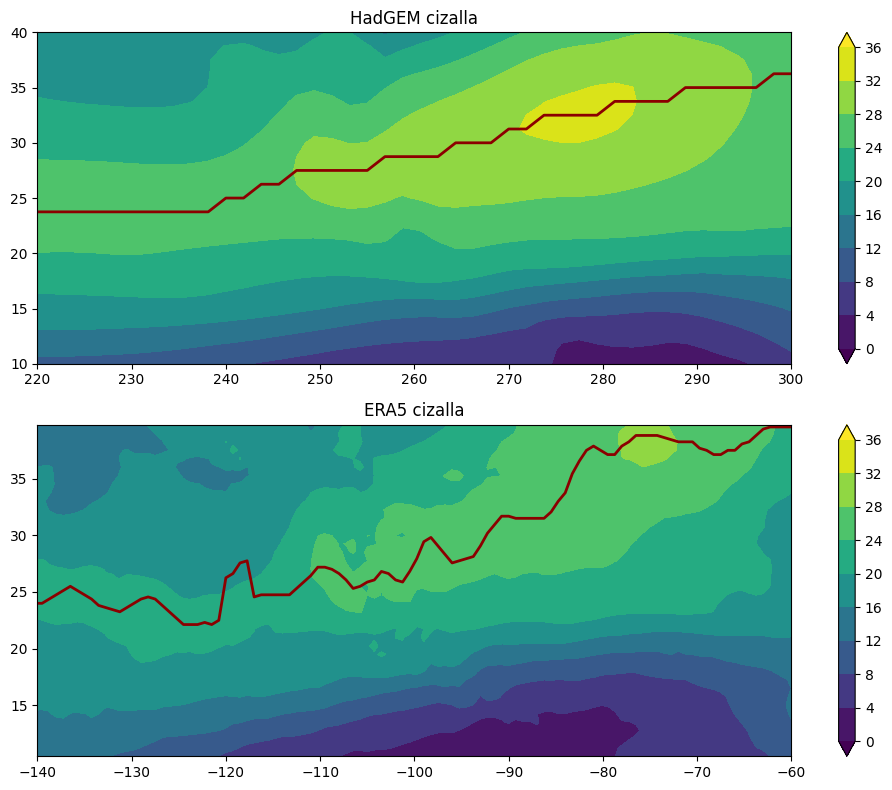

In [26]:
fig = plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.contourf(hg.lon,hg.lat,hg,levels=np.arange(0,37,4),extend='both')
plt.plot(hg.lon,lat_max_diff_hg,c='darkred',linewidth=2)
plt.xlim([220,300])
plt.colorbar()
plt.title('HadGEM cizalla')
plt.subplot(212)
plt.contourf(e5.longitude,e5.latitude,e5 ,levels=np.arange(0,37,4),extend='both')
plt.plot(e5.longitude,lat_max_diff_e5,c='darkred',linewidth=2)
plt.xlim([-140,-60])
plt.title('ERA5 cizalla')
plt.colorbar()
plt.tight_layout()

In [52]:
e5 

<xarray.DataArray (latitude: 40, longitude: 214)> Size: 34kB
array([[20.741749, 21.077827, 20.982395, ...,  8.365894,  8.856231,
         9.711295],
       [21.77642 , 21.742367, 21.842594, ...,  8.554111,  9.29458 ,
         9.797328],
       [22.349113, 22.26162 , 22.476028, ...,  9.428312,  9.982037,
        10.284244],
       ...,
       [10.568092, 10.869845, 11.080477, ..., 15.469931, 15.256943,
        15.175888],
       [ 9.673052, 10.121802, 10.134328, ..., 13.289055, 13.255234,
        13.188141],
       [ 8.59918 ,  8.760256,  8.928471, ..., 11.206827, 10.958311,
        11.110165]], dtype=float32)
Coordinates:
    number     int64 8B 0
  * latitude   (latitude) float64 320B 39.75 39.0 38.25 37.5 ... 12.0 11.25 10.5
  * longitude  (longitude) float64 2kB -159.8 -159.0 -158.2 ... -1.5 -0.75 0.0